# Cardiomyocite cells cultures behavior investigation


## Data Analysis and Comparisons

### Optical data visualization

In this first code segment, the aim will be to split the video bits, in order to highlight electrodes, along with the cells within each electrode.

This will be done by:

- Using a highpass filter to split the image based on the darker color of transistor wiring.
- Matrix of electrodes will be determined based on the transistor wires crossings, that split almost right through the middle of an electrode
  (the shift to an electrode will be estimated as a visual estimate in pixels)
- 


In [2]:
###INCLUDES
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import math

In [3]:
###PATHS
media_path = '../../data/'
##FILE TO WORK ON FOR NOW 
file2 = media_path + 'TESTVIDEOS/.10.1.avi'
file1 = media_path + 'TESTVIDEOS/Nifedipine4_CentreG18_basS9_video.AVI'
stream_url = "http:169.254.235.60:8080"
file = file2

#### Original Stream 

In [4]:
cap = cv2.VideoCapture(file)
width  = cap.get(3)   # float `width`
height = cap.get(4)  # float `height`

##Assert
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

##window creation
# Set the display window size
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  #Allow window resizing
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))  #Window size 40% smaller

##READ FRAME BY FRAME
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    #Display Frame
    cv2.imshow('Frame',frame)
    #Exit on Q
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
  #If no frame left close
  else: 
    break
 
cap.release()
cv2.destroyAllWindows()

### Transistor Wiring contours

In [5]:
#####CLEANING CONTOURS
###This function filters noise based on 
def cleanContours(contours):
    new_contours = []
    for contour in contours:
        if (len(contour) > 40):
            new_contours.append(contour)
    return new_contours

In [6]:
###HIGHPASS FILTER FOR TRANSISTORS CONTOURING
    ##DISPLAY OF CONTOURS

cap = cv2.VideoCapture(file)
width  = cap.get(3)   # float `width`
height = cap.get(4)  # float `height`

##Assert
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

##window creation
# Set the display window size
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  #Allow window resizing
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))  #Window size - 40% smaller

##READ FRAME BY FRAME
while True:
    ret, frame = cap.read()
    if ret ==True:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 90, 155, cv2.THRESH_BINARY)
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

        ###COPY FRAME 
        frame_trans_contour = frame.copy()
        #####clean contours and contour rectangle shapes
        clean_wires_contours = cleanContours(contours_wires)

        for contour in clean_wires_contours:
                area = cv2.contourArea(contour)
                if area > 1000:
                    x,y,w,h = cv2.boundingRect(contour)
                    cv2.rectangle(frame_trans_contour, (x, y), (x + w, y + h), (0, 255, 0), 3)   
                            ###drawing raw contours instead
                    #cv2.drawContours(image=frame_trans_contour, contours=clean_wires_contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    #Display Frame
        cv2.imshow('Frame',frame_trans_contour)
    #Exit on Q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



### Electrodes contours
- This version splits the contours of electrodes, based on the side size of a transistor, thus it matches any zoom setting.
- Said "size" of the transistor is obtained in pixel size though vizualisation. For now, an electrode side size is thought to be the exact same.
(100micrometers).
- Each electrode considers a "contour" of their own, which can be seen on the image and in real size, is equal to 5micrometers. 
- Each electrode will be attributed the top and left 'contours' that surround it.
- The shift from A transistor contour, to an electrode's, will be done by shifting bottom, and right.
Below, in the $shift(x , y, tft\_size)$ function the shift is done on $x$, $y$, pixels with the size of the side of the electrode being equal to $tft\_size$ 

In [7]:
### Side of electrode in pixels on the microscope referrence ()
X = Y = 216.5 ###correspond à 100 micromètres
x_elec_side = 121.5 
y_elec_side = 100
##NO scaling to screen tft pixel side size for X_shift, Y_shift. Check below function for scaling
X_shift = X - x_elec_side
Y_shift = Y - y_elec_side
def shift(x, y, tft_size):
    X_shift_scaled = (X_shift*tft_size) / X 
    Y_shift_scaled = (Y_shift*tft_size) / Y
    #print ("SHIFT SCALED : " , X_shift_scaled, Y_shift_scaled, tft_size)
    return round(x + X_shift_scaled), round(y + Y_shift_scaled)

##### Displaying and detecting contour of each electrode
Some variables should be adjusted for better precision : 
- $delay$ : 
- $frame\_nb\_tft\_size$ 
- $thresh\_px$

##### Splitting data from each rectangle into a matrix
Considering the "live" and frame by frame nature of the code, if a electrode is mis-detected or not detected in a single frame, the algorithm will consider the previous detection of it. 
If it is it's first detection, it will be added (see $clean\_rectangle(...)$)
If a rectangle disappears for over 3 frames, then it will be deleted from the general array.

##### Issues to consider
In this first implementation, the squares are disorganized, put into the $bounding\_rectangles$ array. Accessing them might be costly.


In [8]:
###Determines whether a square was already detected :
####If it was, and the new rectangle is smaller in size, it is replaced.
#####If the rectangle is not square shaped, it is also not kept
def clean_rectangle(new_rect, bounding_rectangles, thresh):
    for rect in bounding_rectangles :
        if (abs(new_rect[0] - rect[0]) <= thresh) and (abs(new_rect[1] - rect[1]) <= thresh):
            #########This below case is the case where it is a same or way bigger square. If it is, then we ignore
            if (new_rect[2] >= rect[2] + thresh ) :
                return rect[0], rect[1], rect[2], rect[3]
        else:
            x, y, w, h = new_rect[0], new_rect[1], new_rect[2], new_rect[3]
            bounding_rectangles.append([x, y, w, h])
            return x,y,w,h



In [9]:
###SPECIFIES THE DELAY AT WHICH CONTOUR DETECTION SHOULD BE STARTED
delay = 2 ##in seconds
frame_nb_tft_size = 50 ###number of frames to check for the most common side size
thresh_px = 15 ##general threshhold in pixel for estimates -> should be calculated depending the amount of squares 
##frame count
frame_cnt = 0
tft_size = 0 ##in pixels
tft_sizes = []
bounding_rectangles = [[-100, -111, -222, -333]]

cap = cv2.VideoCapture(file)
width  = cap.get(3)
height = cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)  #Allow window resizing
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))  #Window size - 40% smallerq

while True:
    ret, frame = cap.read()
    if ret ==True:
        frame_cnt+=1
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 170, 220, cv2.THRESH_BINARY)
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        frame_trans_contour = frame.copy()
        clean_wires_contours = cleanContours(contours_wires)
        ###Contour detection and display according to 
        if(frame_cnt >= delay*fps):
            for contour in clean_wires_contours:
                    area = cv2.contourArea(contour)
                    if area > 3000:
                        x,y,w,h = (cv2.boundingRect(contour))
                        if((w!=width or h!=height) and abs(w - h) < thresh_px):
                            x,y,w,h = clean_rectangle((x,y,w,h), bounding_rectangles, thresh_px)
                            tft_sizes.append(w)
                            tft_sizes.append(h)
                            tft_size = max(set(tft_sizes), key = tft_sizes.count)
                            x, y = shift(x, y, tft_size)
                            cv2.rectangle(frame_trans_contour, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 255, 0), 3)
                            #print("TFT SIZE = ", tft_size, tft_sizes)

            ###OPTIM
            thresh_px = round(len(bounding_rectangles)/3)        
            tft_sizes = []
            bounding_rectangles = [[-100, -111, -222, -333]] ###re-initialization of bounding rectangles 


    #Display Frame
        cv2.imshow('Frame',frame_trans_contour)
    #Print on R
    if cv2.waitKey(1) & 0xFF == ord('r'):
        print(bounding_rectangles, tft_size)
    #Exit on Q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

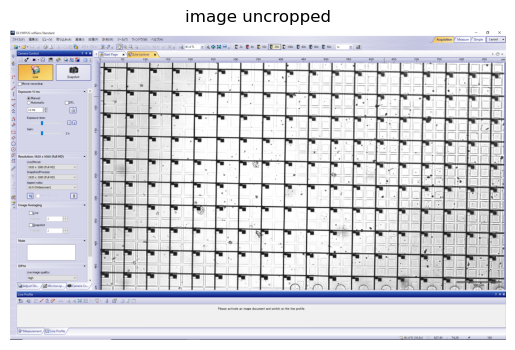

In [10]:
img_crop_test = cv2.imread(media_path + "random/capture.png")
plt.imshow(cv2.cvtColor(img_crop_test, cv2.COLOR_BGR2RGB))
plt.title('image uncropped')
plt.axis('off')  # Turn off axis
plt.show()

#### Isolating top left electrode, User coordinates
This adds a feature that isolates the top left electrode (highlighted in red), from the previous frame, and then asks the User for the "coordinates" for the said electrode so as to label every other electrode
Once the coordinate has been obtained, it maps the rest of the grid

In [11]:
def top_left_electrode(bounding_rectangles, smallest_x, smallest_y):
        if(len(bounding_rectangles)==1):
                print("NO bounding rectangles registered yet")
                return float('inf'), float('inf'), -math.inf, -math.inf
        
        #Convert bounding_boxes to a NumPy array
        bounding_rectangles_array = np.array(bounding_rectangles[1:])
        #Extract x and y coordinates from bounding_rectangles_array
        x_coordinates = bounding_rectangles_array[:, 0]
        y_coordinates = bounding_rectangles_array[:, 1]

        #Find the indices of the smallest x and y values
        min_x_index = np.argmin(x_coordinates)
        min_y_index = np.argmin(y_coordinates)
        max_x_index = np.argmax(x_coordinates)
        max_y_index = np.argmax(y_coordinates)

        #Get the smallest x and y values
        smallest_x = x_coordinates[min_x_index]
        smallest_y = y_coordinates[min_y_index]
        biggest_x = x_coordinates[max_x_index]
        biggest_y = y_coordinates[max_y_index]
        return smallest_x, smallest_y, biggest_x, biggest_y

In [12]:
def annote_positions(tft_size, frame, smallest_x, smallest_y, width, height):
    font = cv2.FONT_HERSHEY_SIMPLEX
    pos_x_increment, pos_y_increment = smallest_x + tft_size/2 -(width+width/3)/width,  smallest_y + tft_size/2 - (height+height/3)/height ##minus (height+height/3)/height for text width or height
    cnt = 0 
    ###write down X axis
    while(pos_x_increment < width):
        cv2.putText(frame, str(cnt),(round(pos_x_increment), round(smallest_y - tft_size/10)), font, (width+width/3)/width, (0, 0, 255), 2, cv2.LINE_AA)
        pos_x_increment = pos_x_increment + tft_size
        cnt = cnt+1
    cnt = 0
    while(pos_y_increment < height):
        cv2.putText(frame, str(cnt), (round(smallest_x - tft_size/10), round(pos_y_increment)), font, (height+height/3)/height, (0, 0, 255), 2, cv2.LINE_AA)
        pos_y_increment = pos_y_increment + tft_size
        cnt = cnt+1


#### Stream crop function
This function serves in the case that direct camera access is restricted. It isolates the video stream from the software on screen, by removing to the left, and to the top, up to tft_size/2.

In [13]:
def stream_crop(smallest_x, smallest_y, biggest_x, biggest_y, frame):
    return frame[smallest_x:biggest_x, smallest_y:biggest_y]

In [14]:
delay = 2 
frame_nb_tft_size = 50
thresh_px = 15
frame_cnt = 0
tft_size = 0
tft_sizes = []
bounding_rectangles = [[-100, -111, -222, -333]]
is_top_left_electrode_annotated = False
pos_annoted = False
pos_written = False

##Coordinates of top left corner electrode
smallest_x, smallest_y, biggest_x, biggest_y = float('inf'), float('inf'), -math.inf, -math.inf

cap = cv2.VideoCapture(file)
width  = cap.get(3)
height = cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))

while True:
    ret, frame = cap.read()
    if ret ==True:
        frame_cnt+=1
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 160, 205, cv2.THRESH_BINARY)
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        frame_trans_contour = frame.copy()
        clean_wires_contours = cleanContours(contours_wires)
        ###Contour detection and display according to 
        if(frame_cnt >= delay*fps):
            pos_written = False
            for contour in clean_wires_contours:
                    area = cv2.contourArea(contour)
                    if area > 3000:
                        x,y,w,h = (cv2.boundingRect(contour))
                        if((w!=width or h!=height) and abs(w - h) < thresh_px):
                            x,y,w,h = clean_rectangle((x,y,w,h), bounding_rectangles, thresh_px)
                            tft_sizes.append(w)
                            tft_sizes.append(h)
                            tft_size = max(set(tft_sizes), key = tft_sizes.count)
                            if(abs(x - smallest_x) <= thresh_px and abs(y - smallest_y) <= thresh_px):
                                x, y = shift(x, y, tft_size)
                                cv2.rectangle(thresh, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 0, 255), 3)
                                is_top_left_electrode_annotated = True
                            else:
                                x, y = shift(x, y, tft_size)
                                cv2.rectangle(thresh, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 255, 0), 3)
                        if(pos_annoted and not pos_written):
                            annote_positions(tft_size, frame_trans_contour, smallest_x, smallest_y, width, height)
                            pos_written = True
            #Input on w
            if cv2.waitKey(1) & 0xFF == ord('w'):
                X_input = input("Please write x coordinate of the highlighted red electrode.")
                Y_input = input("Please write y coordinate of the highlighted red electrode.")
                pos_annoted = True
                print(X_input,Y_input)


            ###OPTIM
            thresh_px = round(len(bounding_rectangles)/3)
            tft_sizes = []
            smallest_x, smallest_y, biggest_x, biggest_y = top_left_electrode(bounding_rectangles, smallest_x, smallest_y)
            bounding_rectangles = [[-100, -111, -222, -333]]


    #Display Frame
        '''if(is_top_left_electrode_annotated):
            cv2.imshow('Frame',stream_crop(smallest_x, smallest_y, biggest_x, biggest_y, frame_trans_contour))
        else:'''
        cv2.imshow('Frame',thresh)
    

    #Print on p
    if cv2.waitKey(1) & 0xFF == ord('p'):
        print(bounding_rectangles, tft_size)
        
    #Exit on q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

#### Data Split into a np array

#### Video recording
This part of the algorithm records a video along with the data associated to each electrode, delimited by "bounding_rectangles". 
- While the video is being recorded, data from each bounding rectangle data according to time, and according to it's gate and position is saved into a file, and input data for the top left electrode coordinates is also stored.
- Post processing of the data, to analyze and combine it to other forms of data will allow the association and correction of electrode coordinates, along with the timestamps associated to them, following a specific time rate.
- Cropping of the video or electrophysiological data to fit


#### Exceptions :

- (Maybe )This approach considers cases where FPS is too slow or too rapid, by adjusting the frame rate in accordance to the set frame rate.
- It saves each bounding rectangle data according to time, and according to it's gate and position.

In [15]:
import os
from datetime import datetime
data_path = "C:/Users/radja/Documents/COURS/RSRC/CARDIO-visualization/data/"
rect_path = data_path + 'bounding_rect_data/'
vid_path  = data_path + 'video_data/'

#### Clean Rectangle function update, to save each rectangle into a file

In [16]:
def rect_coordinates(top_left_X_input, top_left_Y_input, bounding_rectangles):
    return

In [17]:
def clean_rectangle(new_rect, bounding_rectangles, thresh, filename, frame_nb, tft_size):
    ###Writes date time at which the very first 'square' of data can be processed. 
    date_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
    new_x, new_y = shift(new_rect[0], new_rect[1], tft_size)
    for rect in bounding_rectangles :
        if (abs(new_x - rect[0]) <= thresh) and (abs(new_y - rect[1]) <= thresh):
            #########This below case is the case where it is a same or way bigger square. If it is, then we ignore
            if (new_rect[2] >= rect[2] + thresh ) :
                return rect[0], rect[1], rect[2], rect[3]
        else:
            x, y, w, h = new_x, new_y, new_rect[2], new_rect[3]
            bounding_rectangles.append([x, y, w, h])
            if not os.path.exists(filename):
                with open(filename, 'w') as file_to_write:
                    file_to_write.write(f'{date_time}\n')
            ###add to file
            with open(filename, 'a') as file_to_write:
                file_to_write.write(f'{frame_nb} {x} {y} {w} {h}\n')
            return x,y,w,h

In [18]:
delay = 2 
frame_nb_tft_size = 50
thresh_px = 15
frame_cnt = 0
frame_previous = -1
tft_size = 0
tft_sizes = []
bounding_rectangles = [[-100, -111, -222, -333]]
is_top_left_electrode_annotated = False
pos_annoted = False
pos_written = False

##Coordinates of top left corner electrode
smallest_x, smallest_y, biggest_x, biggest_y = float('inf'), float('inf'), -math.inf, -math.inf

cap = cv2.VideoCapture(file)
width  = cap.get(3)
height = cap.get(4)
fps = cap.get(cv2.CAP_PROP_FPS)
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Frame', round(width*0.6), round(height*0.6))

#Define the codec
fourcc = cv2.VideoWriter_fourcc(*'XVID')
###file name
now = datetime.now()
date_str, time_str = now.strftime("%d-%m-%Y"), now.strftime("%H-%M")
output_name = f"{date_str}_{time_str}"
output_video_name = output_name + '.avi'
###videoWriter Object
out = cv2.VideoWriter(vid_path + output_video_name, fourcc, 20.0, (int(width), int(height))) 

while True:
    ret, frame = cap.read()
    if ret ==True:
        frame_cnt+=1
        if(frame_previous>frame_cnt):
            print("unexpected frame reset")
        frame_previous = frame_cnt
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 90, 155, cv2.THRESH_BINARY) ###90 155 thresh best settings for sample videos
        contours_wires, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
        frame_trans_contour = frame.copy()
        clean_wires_contours = cleanContours(contours_wires)
        ###Contour detection and display according to 
        if(frame_cnt >= delay*fps):
            pos_written = False
            for contour in clean_wires_contours:
                    area = cv2.contourArea(contour)
                    if area > 3000:
                        x,y,w,h = (cv2.boundingRect(contour))
                        if((w!=width or h!=height) and abs(w - h) < thresh_px):
                            x,y,w,h = clean_rectangle((x,y,w,h), bounding_rectangles, thresh_px, rect_path + output_name, frame_cnt, tft_size)
                            tft_sizes.append(w)
                            tft_sizes.append(h)
                            tft_size = max(set(tft_sizes), key = tft_sizes.count)
                            if(abs(x - smallest_x) <= thresh_px and abs(y - smallest_y) <= thresh_px):
                                #x, y = shift(x, y, tft_size)
                                cv2.rectangle(frame_trans_contour, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 0, 255), 3)
                                is_top_left_electrode_annotated = True
                            else:
                                #x, y = shift(x, y, tft_size)
                                cv2.rectangle(frame_trans_contour, (x, y), (x + round(tft_size), y + round(tft_size)), (0, 255, 0), 3)
                        if(pos_annoted and not pos_written):
                            annote_positions(tft_size, frame_trans_contour, smallest_x, smallest_y, width, height)
                            pos_written = True
            #Input on w
            if cv2.waitKey(1) & 0xFF == ord('w'):
                X_input_top_left = input("Please write x coordinate of the highlighted red electrode.")
                Y_input_top_left = input("Please write y coordinate of the highlighted red electrode.")
                pos_annoted = True


            ###OPTIM
            thresh_px = round(len(bounding_rectangles)/3)
            tft_sizes = []
            smallest_x, smallest_y, biggest_x, biggest_y = top_left_electrode(bounding_rectangles, smallest_x, smallest_y)
            bounding_rectangles = [[-100, -111, -222, -333]]


    #Display Frame
        '''if(is_top_left_electrode_annotated):
            cv2.imshow('Frame',stream_crop(smallest_x, smallest_y, biggest_x, biggest_y, frame_trans_contour))
        else:'''
        out.write(frame)  
        cv2.imshow('Frame',frame_trans_contour)
    

    #Print on p
    if cv2.waitKey(1) & 0xFF == ord('p'):
        print(bounding_rectangles, tft_size)
        
    #Exit on q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(f'FRAME NB : {frame_cnt}')
        with open(rect_path + output_name, 'a') as file_rect:
                file_rect.write(f'{frame_cnt}\n')
        break
    

cap.release()
out.release()
cv2.destroyAllWindows()

FRAME NB : 27


### Additional Details
There are some additional details to consider. 
This implementation does not take consideration : 
- potential tilt of the camera stream. A further implementation should take it into consideration.
- Individual camera differences, a calibration with a check board might be necessary.
- check sudden displacement and recalculate top left electrode position.

## Variable extraction
### Displacement Factor over a single electrode
Displacement factor will figure the "amount of movement" within one electrode in an electrode array. It will track each pixel's (or each window of pixels) displacement over a certain time frame.

#### STEPS
There are several steps to this process :
- Function to isolate electrode at a given frame from the corresponding file
- Function to compare one frame's specific electrode to another frame
- Function to take a video stream and do the previous process to every single frame and keep a general value over a specific time frame.

It englobes a first function calculate_displacement_between_two_frames, which will calculate displacement of pixels inside an electrode between two specific frames f1 and f2. 
Within a window of size window_size * window_size pixels, the function will sum up the number of pixels each pixel has 'moved' of, without consideration of the direction, in a variable displacement_sum. 
It will then iterate over the entire electrode of coordinates x, y, and width w and height h, while keeping count of the amount of areas covered. For example, if window_size is equal to 1 pixel, then the count will be of x * y / 1 areas. Otherwise it will be approximately of ((x * y) / window_size) + remaining. Then we obtain a displacement_mean value from the sum and the count which corresponds to the total average movement within an electrode between two frames. 

#### Parsing Function 
This function will parse a bounding rectangle file and give relevant data to the user.

In [23]:
def parse_bounding_rect_file(bounding_rect_file):
    with open(bounding_rect_file, 'r') as f:
        lines = f.readlines()
    
    #The first line is the start time, the second line first number is start frame number
    # # and the last line is the final frame number
    start_time = lines[0].strip()
    start_frame_number = int(lines[1].strip().split()[0])
    bounding_boxes = []

    for line in lines[1:-1]:
        parts = line.strip().split()
        if len(parts) == 5:  # Valid bounding box line
            frame, x, y, w, h = map(int, parts)
            bounding_boxes.append((frame, x, y, w, h))
    final_frame_number = int(lines[-1].strip())

    return start_time, start_frame_number, final_frame_number, bounding_boxes

#### Isolate Electrode
To obtain the data of an electrode over 2 frames, the function isolate_electrode will look over the bounding_rect_data file associated to the current file. It is a file containing strings of format "FRAME X Y W H\n" while listining down electrodes information given in each frame separately. The first line of the file is the date time the recording started at. The very last line is the final Frame number.
isolate_electrode will use of a threshhold of a few pixels (max5) so as to consider an error margin.
It will return an erray of pixels (black and white) which contains data of the said electrode at a given frame.

file opened
found electrode at given frame


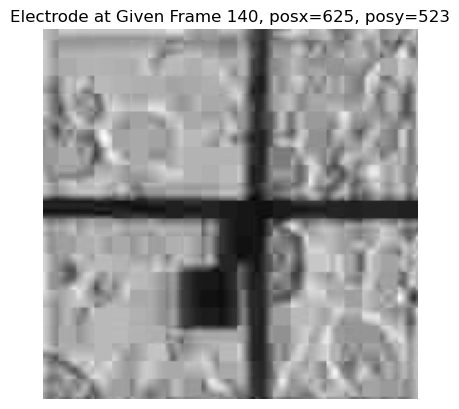

In [20]:
def isolate_electrode(given_frame, x, y, w, h, thresh, bounding_rect_file, video_file):
    ###PARSE
    start_time, start_frame_number, final_frame_number, bounding_boxes = parse_bounding_rect_file(bounding_rect_file)

    ##video & init
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        raise ValueError("Could not open the video file")
    electrode_data = []
    print("file opened")

    #Iterate over bounding boxes and find those matching criteria within thresh
    for frame_num, bx, by, bw, bh in bounding_boxes:
        #Check if the bounding box is within the threshold
        if frame_num == given_frame and abs(bx - x) <= thresh and abs(by - y) <= thresh and abs(bw - w) <= thresh and abs(bh - h) <= thresh:
            print("found electrode at given frame")
            # Move to the corresponding frame in the video
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()

            if not ret:
                if(frame_num==final_frame_number):
                    cap.release()
                    break
                raise ValueError(f"Could not read frame {frame_num} from the video")

            #Extract electrode region of interest
            roi = frame[by:by+bh, bx:bx+bw]
            #validness check
            if roi.size == 0:
                raise ValueError(f"Invalid ROI extracted for frame {frame_num}.")
            electrode_data = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    cap.release()
    return electrode_data, start_frame_number, final_frame_number

#TEST
video_file_path = vid_path + '02-08-2024_17-51.avi'
bounding_rect_file_path = rect_path + '02-08-2024_17-51'

electrode, start,end = isolate_electrode(given_frame=140, x=625, y=523, w=168, h=166, thresh=5, bounding_rect_file=bounding_rect_file_path, video_file=video_file_path)
plt.imshow(electrode, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.title('Electrode at Given Frame 140, posx=625, posy=523')
plt.show()

#### Displacement between two frames
Some parameters need to be ensured. Same size between two windows, and window_size needs to be a multiple of the size of the sides of electrodes. Otherwise, the remaining needs to be handled properly. 
The line np.abs(window1.astype(int) - window2.astype(int)) calculates the per-pixel absolute intensity differences between two windows of frames, which measures 'change' within a pixel window.

window1 = [[100, 150, 200], </br>
           [120, 180, 220], </br>
           [140, 160, 240]] </br>

window2 = [[110, 140, 190], </br>
           [130, 170, 210], </br>
           [150, 150, 230]] </br>

abs_diff = [[10, 10, 10], </br>
            [10, 10, 10], </br>
            [10, 10, 10]] </br>


In [21]:
def calculate_displacement_between_two_frames(f1, f2, x,y,w,h, window_size, bounding_rect_file, video_file, thresh_px):
    frame1=isolate_electrode(f1, x, y, w, h, thresh_px, bounding_rect_file, video_file)
    frame2=isolate_electrode(f2, x, y, w, h, thresh_px, bounding_rect_file, video_file)
    displacement_sum = 0 ##init
    num_windows = 0
    remnant = False
    #Ensure the frames are the same size; crop if necessary
    h1, w1 = frame1.shape
    h2, w2 = frame2.shape

    min_height = min(h1, h2)
    min_width = min(w1, w2)

    frame1 = frame1[:min_height, :min_width]
    frame2 = frame2[:min_height, :min_width]

    displacement_sum = 0  # Initialize the displacement sum
    num_windows = 0  # Initialize the count of windows
    
    # Calculate the number of complete windows along each dimension
    num_windows_x = min_width // window_size
    px_remnant_x = min_width % window_size 
    num_windows_y = min_height // window_size
    px_remnant_y = min_width % window_size 
    print(num_windows_x * num_windows_y)
    print(px_remnant_x, px_remnant_y)
    if(px_remnant_x or px_remnant_y != 0):
        remnant = True
        # Iterate over each complete window
    for i in range(num_windows_x + remnant):
        for j in range(num_windows_y + remnant):
            if(num_windows == num_windows_x*num_windows_y and remnant):
                actual_window_height = px_remnant_y
                actual_window_width = px_remnant_x
            else: 
                #Define the window boundaries taking in consideration remaining values
                actual_window_height = min(window_size, frame1.shape[0] - j)
                actual_window_width = min(window_size, frame1.shape[1] - i)
                
            print(actual_window_height, actual_window_width)
            window1 = frame1[i:i + actual_window_height, j:j + actual_window_width]
            window2 = frame2[i:i + actual_window_height, j:j + actual_window_width]

            # Calculate the absolute difference and sum it up
            displacement = np.abs(window1.astype(int) - window2.astype(int))
            displacement_sum += np.sum(displacement)
            num_windows += 1
            print("NUM WINDOW : ", num_windows)
            if(num_windows == num_windows_x*num_windows_y + remnant):
                break
        if(num_windows == num_windows_x*num_windows_y + remnant):
                break

    displacement_mean = displacement_sum / ((num_windows * window_size * window_size))
    return displacement_mean



In [22]:
displacement = calculate_displacement_between_two_frames(f1=140 ,f2 =141, x=625, y=523, w=168, h=166, window_size=5, bounding_rect_file=bounding_rect_file_path, video_file=video_file_path, thresh_px=5)
print(displacement)

file opened
found electrode at given frame
file opened
found electrode at given frame


AttributeError: 'tuple' object has no attribute 'shape'

#### Displacement between all frames of a video stream.
This version of the function calculates the displacement factor over a definite time frame, in a whole video_stream over one electrode.


In [46]:
def displacement_timesteps(x,y,w,h, window_size, bounding_rect_file, video_file, thresh_px, time_frame, fps):
    """
        Calculate the displacement of an electrode over an entire video in specified time frames.

        Args:
            video_file (str): Path to the video file.
            bounding_rect_file (str): Path to the bounding rectangle file.
            x, y, w, h (int): Electrode coordinates and dimensions.
            thresh_px (int): Pixel threshold for electrode detection.
            window_size (int): Size of the window for calculating displacement.
            time_frame (int): Duration in seconds for each displacement calculation.
            fps (int): Frames per second of the video.

        Returns:
            List[float]: Array of displacement mean values over time.
        """
    ###PARSE
    start_time, start_frame_number, final_frame_number, bounding_boxes = parse_bounding_rect_file(bounding_rect_file)
    cap = cv2.VideoCapture(video_file)
    if not cap.isOpened():
        raise ValueError("Could not open the video file")
    #total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the number of frames per time frame
    frames_per_time_frame = time_frame * fps
    
    #Init array to store all the displacement mean values
    displacement_means = []
    #Iterate over video in chunks of time_frame
    for start_frame in range(0, total_frames - frames_per_time_frame, frames_per_time_frame):
        end_frame = start_frame + frames_per_time_frame
        
        # Calculate the displacement mean for the current time frame
        displacement_sum = 0
        frame_count = 0

        # Process each pair of frames in the current time frame
        for f in range(start_frame, end_frame - 1):
            displacement_mean = calculate_displacement_between_two_frames(
                f1=f,
                f2=f + 1,
                x=x,
                y=y,
                w=w,
                h=h,
                window_size=window_size,
                bounding_rect_file=bounding_rect_file,
                video_file=video_file,
                thresh_px=thresh_px
            )
            displacement_sum += displacement_mean
            frame_count += 1

        # Calculate the mean displacement for the time frame
        if frame_count > 0:
            average_displacement = displacement_sum / frame_count
            displacement_means.append(average_displacement)

    cap.release()
    return displacement_means

video_file_path = vid_path + '02-08-2024_17-51.avi'
bounding_rect_file_path = rect_path + '02-08-2024_17-51'
fps = 30
displacement_means = displacement_timesteps(
    video_file=video_file_path,
    bounding_rect_file=bounding_rect_file_path,
    x=625, y=523, w=168, h=166,
    thresh_px=5, window_size=10,
    time_frame=1, fps=fps
)

print(displacement_means)

file opened
file opened


AttributeError: 'tuple' object has no attribute 'shape'

## Image Analysis

- Needs to be independant from : Zoom 

## Threading
